In [1]:
import tensorflow as tf
import numpy as np
import PIL

2023-04-18 11:21:13.287638: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-18 11:21:14.051640: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def display_tf(img):
    display(PIL.Image.fromarray(np.array(img)[:,:,0],'L'))

tf.Tensor(5, shape=(), dtype=int64)
tf.Tensor(5, shape=(), dtype=int64)


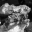

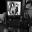

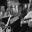

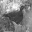

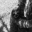

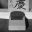

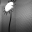

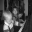

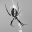

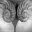

In [17]:
training_dataset = tf.data.Dataset.load('imgnet32y/').take(5)
validation_dataset = tf.data.Dataset.load('imgnet32y_val/').take(5)
print(training_dataset.cardinality())
print(validation_dataset.cardinality())
for X,y in training_dataset.take(5):
    display_tf(X)
for X,y in validation_dataset.take(5):
    display_tf(X)

In [10]:
# From Apache Licensed tensorflow compression example
# https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/data_compression.ipynb

import tensorflow as tf
import tensorflow_compression as tfc
import tensorflow_datasets as tfds

def make_analysis_transform(latent_dims):
  """Creates the analysis (encoder) transform."""
  return tf.keras.Sequential([
      tf.keras.layers.Conv2D(
          20, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2D(
          50, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(
          1024, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          latent_dims, use_bias=True, activation=None, name="fc_2"),
  ], name="analysis_transform")

def make_synthesis_transform():
  """Creates the synthesis (decoder) transform."""
  return tf.keras.Sequential([
      tf.keras.layers.Dense(
          1024, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          8192, use_bias=True, activation="leaky_relu", name="fc_2"),
      tf.keras.layers.Reshape((8, 8, 128)),
      tf.keras.layers.Conv2DTranspose(
          20, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2DTranspose(
          1, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
  ], name="synthesis_transform")

class Imgnet32yCompressionTrainer(tf.keras.Model):
  """Model that trains a compressor/decompressor for MNIST."""

  def __init__(self, latent_dims):
    super().__init__()
    self.analysis_transform = make_analysis_transform(latent_dims)
    self.synthesis_transform = make_synthesis_transform()
    self.prior_log_scales = tf.Variable(tf.zeros((latent_dims,)))

  @property
  def prior(self):
    return tfc.NoisyLogistic(loc=0., scale=tf.exp(self.prior_log_scales))

  def call(self, x, training):
    """Computes rate and distortion losses."""
    # Ensure inputs are floats in the range (0, 1).
    x = tf.cast(x, self.compute_dtype) / 255.
    x = tf.reshape(x, (-1, 32, 32, 1))

    # Compute latent space representation y, perturb it and model its entropy,
    # then compute the reconstructed pixel-level representation x_hat.
    y = self.analysis_transform(x)
    entropy_model = tfc.ContinuousBatchedEntropyModel(
        self.prior, coding_rank=1, compression=False)
    y_tilde, rate = entropy_model(y, training=training)
    x_tilde = self.synthesis_transform(y_tilde)

    # Average number of bits per MNIST digit.
    rate = tf.reduce_mean(rate)

    # Mean absolute difference across pixels.
    # distortion = tf.reduce_mean(abs(x - x_tilde))
    distortion = 1-tf.image.ssim(x,x_tilde,1.0,filter_size=11,filter_sigma=1.5)

    return dict(rate=rate, distortion=distortion)

def pass_through_loss(_, x):
  # Since rate and distortion are unsupervised, the loss doesn't need a target.
  return x

def make_imgnet32y_compression_trainer(lmbda, latent_dims=128):
  trainer =  Imgnet32yCompressionTrainer(latent_dims)
  trainer.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    # Just pass through rate and distortion as losses/metrics.
    loss=dict(rate=pass_through_loss, distortion=pass_through_loss),
    metrics=dict(rate=pass_through_loss, distortion=pass_through_loss),
    loss_weights=dict(rate=1., distortion=lmbda),
  )
  return trainer

def add_rd_targets(image, label):
  # Training is unsupervised, so labels aren't necessary here. However, we
  # need to add "dummy" targets for rate and distortion.
  return image, dict(rate=0., distortion=0.)

def train_imgnet32y_model(lmbda):
  trainer = make_imgnet32y_compression_trainer(lmbda)
  trainer.fit(
      training_dataset.map(add_rd_targets).batch(128).prefetch(8),
      epochs=1,
      validation_data=validation_dataset.map(add_rd_targets).batch(128).cache(),
      validation_freq=1,
      verbose=1,
  )
  return trainer

class Imgnet32yCompressor(tf.keras.Model):
  """Compresses MNIST images to strings."""

  def __init__(self, analysis_transform, entropy_model):
    super().__init__()
    self.analysis_transform = analysis_transform
    self.entropy_model = entropy_model

  def call(self, x):
    # Ensure inputs are floats in the range (0, 1).
    x = tf.cast(x, self.compute_dtype) / 255.
    y = self.analysis_transform(x)
    # Also return the exact information content of each digit.
    _, bits = self.entropy_model(y, training=False)
    return self.entropy_model.compress(y), bits

class Imgnet32yDecompressor(tf.keras.Model):
  """Decompresses MNIST images from strings."""

  def __init__(self, entropy_model, synthesis_transform):
    super().__init__()
    self.entropy_model = entropy_model
    self.synthesis_transform = synthesis_transform

  def call(self, string):
    y_hat = self.entropy_model.decompress(string, ())
    x_hat = self.synthesis_transform(y_hat)
    # Scale and cast back to 8-bit integer.
    return tf.saturate_cast(tf.round(x_hat * 255.), tf.uint8)

def make_imgnet32y_codec(trainer, **kwargs):
  # The entropy model must be created with `compression=True` and the same
  # instance must be shared between compressor and decompressor.
  entropy_model = tfc.ContinuousBatchedEntropyModel(
      trainer.prior, coding_rank=1, compression=True, **kwargs)
  compressor = Imgnet32yCompressor(trainer.analysis_transform, entropy_model)
  decompressor = Imgnet32yDecompressor(entropy_model, trainer.synthesis_transform)
  return compressor, decompressor

In [12]:
trainer = train_imgnet32y_model(lmbda=2000)
trainer.load_weights('imgnet32y_trainer.h5')
compressor, decompressor = make_imgnet32y_codec(trainer)

1/1 [==============================] - ETA: 0s - loss: 2247.7178 - distortion_loss: 0.9920 - rate_loss: 263.6259 - distortion_pass_through_loss: 0.9920 - rate_pass_through_loss: 263.6259

1/1 [==============================] - 4s 4s/step - loss: 2247.7178 - distortion_loss: 0.9920 - rate_loss: 263.6259 - distortion_pass_through_loss: 0.9920 - rate_pass_through_loss: 263.6259 - val_loss: 2234.5063 - val_distortion_loss: 0.9865 - val_rate_loss: 261.4550 - val_distortion_pass_through_loss: 0.9865 - val_rate_pass_through_loss: 261.4550


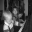

In [24]:
X_val = []
for X,y in validation_dataset.take(5):
    X_val.append(X)
X_val = tf.stack(X_val)
display_tf(X_val[2])

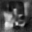

In [25]:
strings, entropies = compressor(X_example)
reconstructions = decompressor(strings)
display_tf(reconstructions[2])

In [26]:
print(f"String representation in hexadecimal: 0x{strings[2].numpy().hex()}")
print(f"Number of bits actually needed to represent it: {entropies[2]:0.2f}")

String representation in hexadecimal: 0x42663f5aac295c10d78d281990de401383816c81bb02dbb74fb7112f99e67fc8
Number of bits actually needed to represent it: 257.20
